In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [4]:
# Load settings
from backend import sett, postgres
from backend.utils.frame import Frame
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [5]:
# Connect to database
db = postgres.connect('polylet')

NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.047 s)


In [6]:
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("PromptDataExtraction/notebooks/matplotlib.mplstyle")
except:
    try:
        plt.style.use("~/matplotlib.mplstyle")
    except: pass

In [7]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

In [10]:
def timings(seconds : int):
    # Total time on the pipeline.
    print(str(datetime.timedelta(seconds = seconds)))
    print(f"{seconds / 3600 :.2f} hours")

In [7]:
method = postgres.raw_sql("""
    Select * From extraction_methods 
    Where dataset = 'data1' and name like '%-gpt35-similar-full';
""")
method

[Row(name='lcst-gpt35-similar-full', dataset='data1', model='gpt-3.5-turbo', api='openai', para_subset='lcst_ner_full', extraction_info={'user': 'sonakshi', 'shot_selector': 'similar', 'n_shots': 1, 'api_retry_delay': 60, 'delay_multiplier': 0.5, 'max_api_retries': 1, 'api_request_delay': 0.01, 'temperature': 0.001, 'prompt': "Extract all lower critical solution temperature values in JSONL format with 'material', 'property', 'value', 'condition' columns.", 'shot_nrecords': 2, 'shot_keywords': 'false'}, id=181, date_added=datetime.datetime(2023, 10, 23, 14, 38, 35, 774371, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000)))),
 Row(name='tm-gpt35-similar-full', dataset='data1', model='gpt-3.5-turbo', api='openai', para_subset='tm_ner_full', extraction_info={'user': 'sonakshi', 'shot_selector': 'similar', 'n_shots': 1, 'api_retry_delay': 60, 'delay_multiplier': 0.5, 'max_api_retries': 1, 'api_request_delay': 0.01, 'temperature': 0.001, 'prompt': "Extract all melting temp

In [8]:
# Number of materials extracted.
execute("""
      SELECT count(*) FROM extracted_materials em
      WHERE em.method_id >= 175 and em.method_id <= 202
      """)

,count
0,161923


In [9]:
# Number of properties extracted.
execute("""
        SELECT em.name, count(*) FROM extracted_properties ep
        JOIN extraction_methods em ON em.id = ep.method_id
        WHERE ep.method_id >= 175 and ep.method_id <= 202
        group by em.name, ep.method_id;
        """)

,name,count
0,bandgap-gpt35-similar-full,15097
1,cs-gpt35-similar-full,18194
2,dc-gpt35-similar-full,13507
3,eab-gpt35-similar-full,15414
4,hardness-gpt35-similar-full,16075
5,ionic_cond-gpt35-similar-full,12366
6,ri-gpt35-similar-full,67
7,tc-gpt35-similar-full,14561
8,td-gpt35-similar-full,16248
9,tg-gpt35-similar-full,15626


### Tg extracted data

In [10]:
# Number of materials extracted.
execute("""
      SELECT count(*) FROM extracted_materials em
      WHERE em.method_id = 180
      """)

,count
0,13560


In [11]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = 180
        --group by ep.method_id;
        """)

,count
0,15626


In [12]:
tg_data = execute("""
        SELECT ep.numeric_value FROM extracted_properties ep
        WHERE ep.method_id = 180
        --group by ep.method_id;
        """)

tg_data

,numeric_value
0,-40.0
1,65.0
2,67.0
3,14.0
4,39.0
...,...
15621,240.0
15622,357.6
15623,240.0
15624,330.0


In [15]:
print(min(tg_data['numeric_value']))
print(max(tg_data['numeric_value']))

-1415.0
156320.0


(-2000.0, 2000.0)

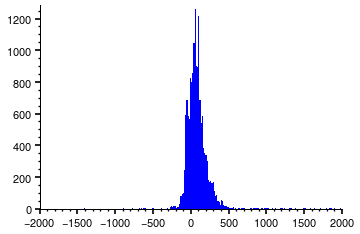

In [14]:
plt.hist(tg_data, bins=10000, color='blue')
plt.xlim(-2000, 2000)

In [2]:
#Total time so far
!grep "All done." filtered_paras/full-corpus/gpt/*full.log | awk -F '(took | s)' '{sum += $2} END {print sum}'

902329


In [11]:
timings(902329)

10 days, 10:38:49
250.65 hours
